In [1]:
COLS_EXCLUDE = ['Median Sale Price','Region','neighborhood',
                'location','city','property_type','state',
                'Month of Period End', 'Median_Sale_Price_Bin', 'neighborhood_num',
                'Month of Period End', 'Unamed: 0', 'Median Sale Price MoM', 'Median Sale Price YoY']

ESTIMATORS = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
DEPTH = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200]
THRESH = 0.1

DATA = 'san_jose_property.csv'

In [2]:
import csv
import itertools
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import confusion_matrix
from string import punctuation

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.around(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def make_histogram(data, bins):
    fig, ax = plt.subplots()

    # histogram our data with numpy
    n, bins = np.histogram(data, bins)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n


    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    plt.show()

In [5]:
def plot_accuracy(performance, estimators, title='', xlabel='', ylabel=''):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(estimators, performance)
    plt.show();

In [81]:
def plot_scatterplot(x, y, title='', xlabel='', ylabel=''):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x, y[0], c='r')
    plt.scatter(x, y[1], c='b')
    plt.xlim(0, len(y[1]))
    plt.show();

In [6]:
# x_train has 70% of the dataset
# x_test has 30% of the dataset
# ignore y_train and y_test
# Regression: Train on x_train, remove non-numerical columns first!
# Test on x_test

# splits dataset up into training (70%) and testing (30%) sets
# evenly based on neighborhood

def split_test_train(total, stratify_col):
    total2 = total.copy(deep=True)
    y = total2[stratify_col]
    x = total2
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
    return (x_train, x_test, y_train, y_test)

In [7]:
# fits a regression model to a training set
def model(x_train, model, label, cols_exclude=COLS_EXCLUDE):
    X = x_train.loc[:, x_train.columns.difference(cols_exclude)]
    Y = x_train.loc[:, label]
    model.fit(X, Y)
    return (model)

In [8]:
def predict(x_test, model, label):
    X_test = x_test.loc[:, x_train.columns.difference(COLS_EXCLUDE)]
    Y_test = x_test.loc[:, label]
    return (model.predict(X_test), Y_test)

In [9]:
# how many of the predicted prices were within
# thresh % of the actual price?
# return a ratio

def evaluate(y_pred, y_test, thresh):
    assert len(y_pred) == len(y_test)
    result = []
    for (pred, test) in zip(y_pred, y_test):
        result.append(math.fabs((test-pred)/test) <= thresh)
    
    return (float(sum(result))/float(len(result)))

In [10]:
# encode catgorial variable so that it can be used
# in regression
def encode_categorial(df):
    neighborhoods = df.neighborhood.unique()
    for n in neighborhoods:
        df[n] = [1 if x == n else 0 for x in df.neighborhood]
    return (df)

In [11]:
def search_for_estimators(x_train, label, estimators=ESTIMATORS, thresh=THRESH):
    performance = []
    for e in estimators:
        r_forest = model(x_train, ensemble.RandomForestClassifier(n_estimators=e), label)
        Y_pred, Y_test = predict(x_test, r_forest, label)
        performance.append(evaluate(Y_pred, Y_test, thresh))
        
    return (performance)

In [12]:
# search for optimal depth of the random forest
def search_for_depth(x_train, label, depths=DEPTH, thresh=THRESH):
    performance = []
    for d in depths:
        r_forest = model(x_train, ensemble.RandomForestClassifier(max_depth=d), label)
        Y_pred, Y_test = predict(x_test, r_forest, label)
        performance.append(evaluate(Y_pred, Y_test, thresh))
        
    return (performance)

In [13]:
total = pd.read_csv(DATA)

In [14]:
forest_df = encode_categorial(total.copy())
x_train, x_test, _, _ = split_test_train(forest_df, 'Median_Sale_Price_Bin')

### Search for optimal parameters

In [15]:
estimator_perf = search_for_estimators(x_train, 'Median Sale Price')

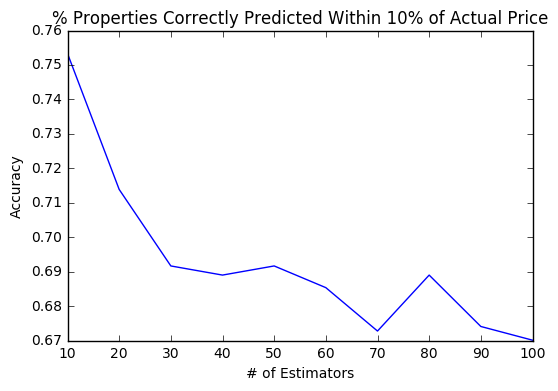

In [16]:
plot_accuracy(estimator_perf, ESTIMATORS, 
              title='% Properties Correctly Predicted Within 10% of Actual Price',
             xlabel='# of Estimators', ylabel='Accuracy')

In [17]:
depth_perf = search_for_depth(x_train, 'Median Sale Price')

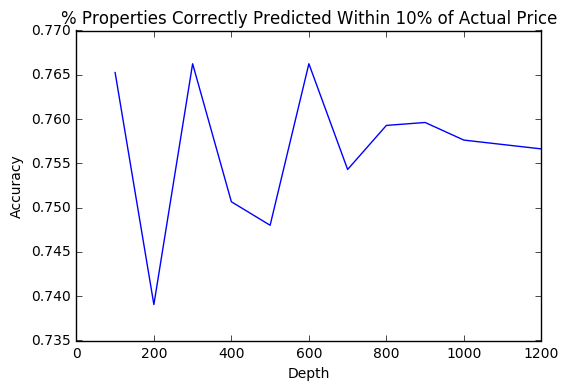

In [18]:
plot_accuracy(depth_perf, DEPTH,
             title='% Properties Correctly Predicted Within 10% of Actual Price',
             xlabel='Depth', ylabel='Accuracy')

### Predict the price range of the property

In [19]:
r_forest = model(x_train, ensemble.RandomForestClassifier(n_estimators=1000), 
                 'Median_Sale_Price_Bin')

In [20]:
Y_pred, Y_test = predict(x_test, r_forest, 'Median_Sale_Price_Bin')

Normalized confusion matrix
[[ 0.70420168  0.26722689  0.02857143  0.        ]
 [ 0.05953488  0.8055814   0.13116279  0.00372093]
 [ 0.00770077  0.17931793  0.78217822  0.03080308]
 [ 0.00228833  0.0778032   0.35011442  0.56979405]]


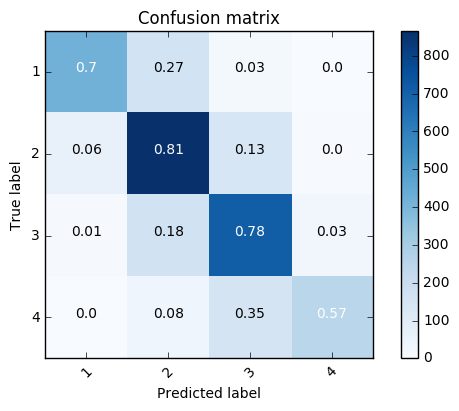

In [21]:
cm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, np.unique(Y_pred), normalize=True)
plt.show()

### Predict the price of the property

In [22]:
x_train, x_test, _, _ = split_test_train(forest_df, 'Median Sale Price')
r_forest = model(x_train, ensemble.RandomForestClassifier(max_depth=600, n_estimators=10, warm_start=True), 
                 'Median Sale Price')

In [23]:
Y_pred, Y_test = predict(x_test, r_forest, 'Median Sale Price')

In [24]:
print (evaluate(Y_pred, Y_test, THRESH))

0.747347480106


In [83]:
forest_df_2017 = pd.read_csv('san_jose_properties_2017.csv')

### January 2017 property predictions vs actual price

In [55]:
r_forest = model(total, ensemble.RandomForestClassifier(max_depth=600, n_estimators=10, warm_start=True), 
                 'Median Sale Price')

In [58]:
X_test = forest_df_2017.loc[:, forest_df_2017.columns.difference(COLS_EXCLUDE)]
Y_test = forest_df_2017.loc[:, 'Median Sale Price']
Y_pred, Y_test = (r_forest.predict(X_test), Y_test)

In [59]:
print (evaluate(Y_pred, Y_test, THRESH))

0.867256637168


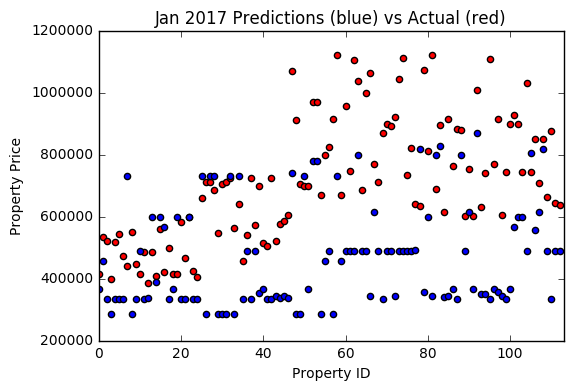

In [82]:
plot_scatterplot(range(len(Y_test)), [Y_test, Y_pred], title='Jan 2017 Predictions (blue) vs Actual (red)',
                ylabel='Property Price', xlabel='Property ID')